# Sub population Analysis 
\[_In case you’re unable to see the atoti visualizations in GitHub, try viewing the notebook in [nbviewer](https://nbviewer.org/github/atoti/notebooks/blob/main/notebooks/01-use-cases/other-industries/sub-population-analysis/main.ipynb)._]

### Objective:

In this notebook, we shall be doing a subpopulation analysis on the predictions from an ML model.

We shall be using [atoti](https://www.atoti.io/) to create the data cubes and doing the analysis. 

For the uninitiated, atoti is a python library that enables data scientists to explore the predictions of their models and seamlessly share the results with the business stakeholders.  

<div style="text-align:center"><a href="https://www.atoti.io/?utm_source=gallery&utm_content=subpopulation" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/discover.png" alt="atoti table" /></a></div>

### Dataset:

**A data set from the insurance domain is used here.** 
An insurance company that has provided Health Insurance to its customers now needs to predict whether the policyholders (customers) from the past year will also be interested in Vehicle Insurance provided by the company. The dataset has been obtained from the Jantahack organized by [analytics vidya.](https://datahack.analyticsvidhya.com/contest/janatahack-cross-sell-prediction/#ProblemStatement)


### Steps:

**1. Preprocessing**
* Import the datasets and train-val split

**2. Loading Model Predictions**
* Evaluate model predictions

**3. Goofing up the prediction**

**4. Loading data in atoti**

**3. Further analysis**

# Step 1: Preprocessing

## Loading the datasets

In [1]:
# Importing the necessary packages

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
import os
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import random

pd.set_option("display.max_columns", None)

seed_value = 36
os.environ["PYTHONHASHSEED"] = str(seed_value)

random.seed(seed_value)
np.random.seed(seed_value)
import multiprocessing

pd.options.mode.chained_assignment = None

# loading the manually created functions from the _utils.py file
from _utils import process_vehicule_age, change_type

# Importing atoti
import atoti as tt

In [2]:
data = pd.read_csv("https://data.atoti.io/notebooks/insurance/train.csv")

In [3]:
# converting vehicle age to inter and changing datatype for other columns
data = process_vehicule_age(data)
data = change_type(data)

In [4]:
data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44.0,1,28.0,0,2.0,Yes,40454.0,26.0,217.0,1
1,2,Male,76.0,1,3.0,0,1.0,No,33536.0,26.0,183.0,0
2,3,Male,47.0,1,28.0,0,2.0,Yes,38294.0,26.0,27.0,1
3,4,Male,21.0,1,11.0,1,0.0,No,28619.0,152.0,203.0,0
4,5,Female,29.0,1,41.0,1,0.0,No,27496.0,152.0,39.0,0


### We need to reshuffle columns and split the label from the training data

In [5]:
# reshuffling columns

cols = data.columns.tolist()
cols.insert(0, cols.pop(cols.index("Response")))
data = data.reindex(columns=cols)

# splitting the labels from the data

y = data.iloc[:, 0]
X = data.iloc[:, 1:]

## Splitting the train and Validation datasets

In [6]:
# split X in X_train and x_test

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [7]:
# printing the shapes of the new dataframes

print("Train data size: {}\n".format(X_train.shape))
print("Train label size: {}\n".format(y_train.shape))
print("Test data size: {}\n".format(X_val.shape))
print("Test label size: {}\n".format(y_val.shape))

Train data size: (342998, 11)

Train label size: (342998,)

Test data size: (38111, 11)

Test label size: (38111,)



# Step 2: Load model Predictions

In order to stick to the scope of this notebook, we shall be loading the predictions made on the validation dataset above.
These are the predictions from a neural network model, which has been uploaded in a different notebook.


In [8]:
# Predictions from neural network
model_results_nn = pd.read_csv(
    "https://data.atoti.io/notebooks/insurance/prediction_nn_rv.csv"
)

# renaming the result comuln from various models
model_results_nn.columns = ["predicted_response"]

In [9]:
# Here we are only concerned with the val dataset

master_data = X_val.join(y_val)
master_data = master_data.reset_index(drop=True)

In [10]:
# we shall be using the results from the Deep Learning along with the actual labels

master_data = master_data.join(model_results_nn)

master_data["predicted_response"] = master_data["predicted_response"].astype(int)

In [11]:
master_data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,predicted_response
0,200223,Female,21.0,1,3.0,1,0.0,No,20408.0,160.0,72.0,0,0
1,49767,Male,55.0,1,15.0,0,1.0,Yes,37498.0,26.0,102.0,0,1
2,172202,Female,41.0,1,3.0,0,1.0,Yes,2630.0,26.0,90.0,0,1
3,160714,Female,26.0,1,11.0,0,0.0,No,2630.0,151.0,268.0,0,0
4,53273,Male,51.0,1,40.0,0,1.0,Yes,34006.0,124.0,265.0,0,1


In [12]:
# In order to validate the correctness of these metrics, let us calculate these metrics using

print(
    "accuracy score: ",
    metrics.accuracy_score(master_data["Response"], master_data["predicted_response"]),
)
print(
    "precision score: ",
    metrics.precision_score(master_data["Response"], master_data["predicted_response"]),
)
print(
    "recall score: ",
    metrics.recall_score(master_data["Response"], master_data["predicted_response"]),
)
print(
    "F1 score: ",
    metrics.f1_score(master_data["Response"], master_data["predicted_response"]),
)

print(
    "AUC: ",
    metrics.roc_auc_score(master_data["Response"], master_data["predicted_response"]),
)

accuracy score:  0.7050457873055024
precision score:  0.2871456822676335
recall score:  0.9107254860965921
F1 score:  0.4366260712674786
AUC:  0.7931267852950555


## Model Performance:
Here we can see that the model prediction have an **AUC of 0.79 and F1 score of 0.43**

# Step 3: Goofing the predictions:
Now let us try and goof up a bit with the model predictions. 
For the highly valuable customers (the ones with the maximum annual premium), let us see what happens if we simply reverse the model predictions, assuming that the model did not learn anything about those customers. 

This could occur in a real-life scenario because of- 

* Data drift - The characteristic of the key customers has changed over time
* Unrepresentative dataset - The model is trained on a non representative dataset as found in production

In [13]:
master_data.Annual_Premium.quantile(0.95)

55098.0

Only 5% customers pay a annual premium of more than 55098, let us see how the model performs for these and other buckets

In [14]:
# filtering out top customers

master_data2 = master_data.loc[master_data["Annual_Premium"] >= 55048]

In [15]:
master_data3 = master_data.loc[master_data["Annual_Premium"] < 55048]

In [16]:
master_data2["predicted_response"] = (
    master_data2["predicted_response"].map({0: 1, 1: 0}).astype(int)
)

In [17]:
data_set = pd.concat([master_data3, master_data2])

In [18]:
data_set.shape

(38111, 13)

Now let see the overall model performance and the performance on the various subpopulation

# Step 4: Loading predictions in atoti

In [19]:
session = tt.Session()

In [20]:
customer = session.read_pandas(
    data_set,
    table_name="customer",
    types={"Policy_Sales_Channel": tt.type.STRING, "Region_Code": tt.type.STRING},
    keys=["id"],
    default_values={"Response": 0, "predicted_response": 0},
)

In [21]:
customer.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,predicted_response
id,,,,,,,,,,,,
108990,Male,42.0,1,3.0,1,1.0,No,24864.0,152.0,89.0,0,0
307165,Male,23.0,1,28.0,1,0.0,No,38142.0,152.0,102.0,0,0
354351,Male,51.0,1,28.0,0,1.0,Yes,40926.0,26.0,226.0,0,1
295647,Female,51.0,1,28.0,1,1.0,No,50198.0,26.0,21.0,0,0
355237,Male,37.0,1,26.0,1,1.0,No,25530.0,22.0,85.0,0,0


In this use case, we will create the cube in `manual` mode so as to explore ways to manipulate hierarchies and levels.

In [22]:
# creating a cube from this store
cube = session.create_cube(customer, "model_cube", mode="manual")

h = cube.hierarchies
m = cube.measures
l = cube.levels

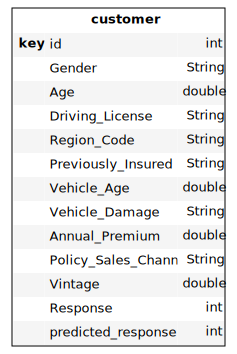

In [23]:
cube.schema

When we create atoti cube in `auto` mode, a `SUM` and a `MEAN` measure are created for each numerical column. Single-level hierarchies are created for each non-numerical column.  
We can create hierarchies for selective columns as shown below, regardless of the column's data type:

In [24]:
h.update(
    {
        name: {name: customer[name]}
        for name in [
            "id",
            "Response",
            "predicted_response",
            "Driving_License",
            "Gender",
        ]
    }
)

In [25]:
h

Hierarchies(_create_hierarchy_from_arguments=<bound method Cube._create_hierarchy_from_arguments of Cube(_name='model_cube', _hierarchies=..., _measures=Measures())>, _cube_name='model_cube')

These columns are created as single-level hierarchies under the dimension `customer` as shown above.  
We could update the dimension name for a given hierarchy with `h[hier_name].dimension = dim_name`.  
For instance, we recursively updated the dimension of the hierarchies to capitalize the first letter of the original dimension name in the below code snippet.

In [26]:
# We create a simple function that helps change the dimension of our hierarchies as we group them into logical categories.
def set_dim(hier_name, dim_name):
    h[hier_name].dimension = dim_name


customer_hierarchy = [
    "id",
    "Response",
    "predicted_response",
    "Driving_License",
    "Gender",
]
[set_dim(hier_name, "Customer") for hier_name in customer_hierarchy]

[None, None, None, None, None]

Review the path to each of the levels in the cube, listed within the brackets in the order of `dimension/hierarchy/level`.  
Dimension name is now `Customer` instead of `customer`.

In [27]:
l

Levels()

### Defining the various measures in atoti  

While deciding on the scope to be used during measure creation, we look at the levels and measures involved.  
For instance, we included `l["id"]` because it is the key of the table where `predicted_response` and `Response` are from.  
In addition, we referenced the `predicted_response` and `Response` levels within the `where` condition. Therefore, we also include these levels under our scope.  

In [28]:
m["true positive"] = tt.agg.sum(
    tt.where(((l["predicted_response"] == 1) & (l["Response"] == 1)), 1, 0),
    scope=tt.OriginScope(l["id"], l["predicted_response"], l["Response"]),
)

m["true negative"] = tt.agg.sum(
    tt.where(((l["predicted_response"] == 0) & (l["Response"] == 0)), 1, 0),
    scope=tt.OriginScope(l["id"], l["predicted_response"], l["Response"]),
)

m["false positive"] = tt.agg.sum(
    tt.where(((l["predicted_response"] == 1) & (l["Response"] == 0)), 1, 0),
    scope=tt.OriginScope(l["id"], l["predicted_response"], l["Response"]),
)


m["false negative"] = tt.agg.sum(
    tt.where(((l["predicted_response"] == 0) & (l["Response"] == 1)), 1, 0),
    scope=tt.OriginScope(l["id"], l["predicted_response"], l["Response"]),
)

In [29]:
cube.query(
    m["true positive"], m["true negative"], m["false positive"], m["false negative"]
)

,true positive,true negative,false positive,false negative
0,"4,089","22,185","11,143",694


#### Here we calculate the following metrics

Precision: What proportion of positive identifications was actually correct

Recall: What proportion of actual positives was identified correctly it is also known as True Positive Rate (TPR).

F1 score conveys the balance between the precision and the recall. It is defined as follows:  

* __F1 Score = 2*((precision*recall)/(precision+recall))__

Specificity: When the actual value is negative, how often is the prediction correct? It is defined by  

* __specificity = TN / (TN + FP)__

False Positive Rate: When the actual value is negative, how often is the prediction incorrect?  

* __false_positive_rate = FP / float(TN + FP)__

In [30]:
m["recall"] = m["true positive"] / (m["true positive"] + m["false negative"])

m["precision"] = m["true positive"] / (m["true positive"] + m["false positive"])

m["accuracy score"] = (m["true positive"] + m["true negative"]) / m[
    "contributors.COUNT"
]

m["f1 score"] = 2 * ((m["recall"] * m["precision"]) / (m["recall"] + m["precision"]))


m["false positive rate"] = m["false positive"] / (
    m["true negative"] + m["false positive"]
)


m["AUC"] = 0.5 - (m["false positive rate"] / 2) + (m["recall"] / 2)

In [31]:
cube.query(m["accuracy score"], m["precision"], m["recall"], m["f1 score"], m["AUC"])

,accuracy score,precision,recall,f1 score,AUC
0,.69,.27,.85,.41,.76


In [32]:
# annual premium buckets

premium = session.read_pandas(
    pd.DataFrame(
        data=[("0 - 10030", i) for i in range(10030)]
        + [("10030 - 31560", i) for i in range(2630, 31560)]
        + [("31560 - 55098", i) for i in range(31560, 55098)]
        + [("55098+", i) for i in range(55098, 448156)],
        columns=["Annual_Premium_group", "Annual_Premium"],
    ),
    keys=["Annual_Premium"],
    table_name="premium_groups",
)

customer.join(premium)

Since our cube is in _manual_ mode, we have to create the hierarchies manually.

In [33]:
h["Annual_Premium_group"] = [premium["Annual_Premium_group"]]
h

Hierarchies(_create_hierarchy_from_arguments=<bound method Cube._create_hierarchy_from_arguments of Cube(_name='model_cube', _hierarchies=..., _measures=Measures())>, _cube_name='model_cube')

In [34]:
session.visualize("Slicing Data on Premium")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

So here is the difference in the model performance:
    

| Metric        | Before           | After manipulation |
| ------------- |:-------------:| -----:|
| AUC  overall    | 0.79 | 0.76|
| AUC  critical subpopulation    | 0.79 | **0.23**|
| F1 overall  | 0.43      |   0.41 |
| F1  critical subpopulation    | 0.43 | **0.03**|

From the pivot table above we can clearly see a drop in the F1 and AUC scores of the customers paying an annual premium of more than 55098.  
Hence we were able to figure out a drastic drop in model performance in one of the critical customer section, thanks to subpopulation analysis.  

**To mitigate this, we need to retrain the model to accomodate these 'high-value' customers.**


# Step 5: Further Analysis

#### To see the model performance on other features

For the **categorical features**, we can simply see the model performance in each of the categories
For the other **numerical features**, we can make the categories and see the breakup of the model performance

In [35]:
# age group buckets
age_groups = session.read_pandas(
    pd.DataFrame(
        data=[("0-30Y", i) for i in range(30)]
        + [("30Y - 40Y", i) for i in range(30, 40)]
        + [("40Y - 50Y", i) for i in range(40, 50)]
        + [("50Y+", i) for i in range(50, 200)],
        columns=["age group", "age"],
    ),
    keys=["age"],
    table_name="age_groups",
)

customer.join(age_groups)

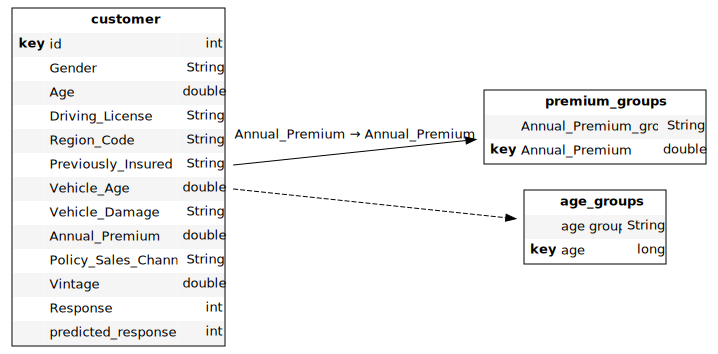

In [36]:
cube.schema

Notice that `age` is created as a hierarchy? That's because it's set as the key for the table `age_groups`.

In [37]:
h["age group"] = [age_groups["age group"]]
h

Hierarchies(_create_hierarchy_from_arguments=<bound method Cube._create_hierarchy_from_arguments of Cube(_name='model_cube', _hierarchies=..., _measures=Measures())>, _cube_name='model_cube')

In [38]:
session.visualize("Slicing Data on Age")

# this slicing in particular, does not seem to make a difference.

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

### Categorical features

In [39]:
session.visualize("Slicing Data based on Gender")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [40]:
session.visualize("Slicing Data based on Driving License")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

<div style="text-align:center"><a href="https://www.atoti.io/?utm_source=gallery&utm_content=subpopulation" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/discover-try.png" alt="atoti table" /></a></div>

# *********** The End **************